In [211]:
import json
import re

In [387]:
def post_processing(judge_text):
    # typo lol
    # judge_text = judge_text.replace("</verduct>", "</verdict>")
    # judge_text = judge_text.replace("</verddict>", "</verdict>")
    judge_text = judge_text.replace("<Verdict>", "<verdict>")
    judge_text = judge_text.replace("</Verdict>", "</verdict>")
    # judge_text = judge_text.replace("<verdict>B</verdict>", "<verdict>[[B]]</verdict>")
    # judge_text = judge_text.replace("Verdict: [[A]] </verdict>", "<verdict>[[A]]</verdict>")
    judge_text = judge_text.replace('<victory> [[A]] </victory>', "<verdict>[[A]]</verdict>")
    judge_text = judge_text.replace('</verdict> [[B]] </verdict>', "<verdict>[[B]]</verdict>")
    judge_text = judge_text.replace('"verdict": "[[A]]"', "<verdict>[[A]]</verdict>")
    judge_text = judge_text.replace('"verdict": [["A"]]', "<verdict>[[A]]</verdict>")
    judge_text = judge_text.replace('"verdict": "[[B]]"', "<verdict>[[B]]</verdict>")
    judge_text = judge_text.replace('"verdict": "[[A]]" "/verdict"', "<verdict>[[A]]</verdict>")
    judge_text = judge_text.replace('"verdict": [[A]]', "<verdict>[[A]]</verdict>")
    judge_text = judge_text.replace('```verdict\n[[B]]\n```', "<verdict>[[B]]</verdict>")
    judge_text = judge_text.replace('{"verdict"} [[B]] {"verdict"}', "<verdict>[[B]]</verdict>")
    judge_text = judge_text.replace('"verdict":"[[B]]"', "<verdict>[[B]]</verdict>")
    judge_text = judge_text.replace('</verdict> [[A]] </verdict>', "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace('"verdict":"[[A]]"', "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace('"`verdict`: [[B]]"', "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace('{"verdict": "B"}', "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace('Audio A performs better than Audio B', "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace('"verdict": [[B]]', "<verdict> [[B]] </verdict>")
    judge_text = judge_text.replace('Based on the analysis, Audio A demonstrates superior pronunciation clarity and accuracy compared to Audio B', "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace('"verdict" [[B]] </verdict>', "<verdict> [[B]] </verdict>")


    judge_text = judge_text.replace('{"verdict"} [[A]] {"verdict"}', "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace('{verdict} [[A]] {verdict}', "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace('[verdict] [[A]] [/verdict]', "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace('/verdict": "[[B]]}"', "<verdict> [[B]] </verdict>")
    # judge_text = judge_text.replace("\verdict\ [[A]] \verdict\\", "<verdict> [[A]] </verdict>")
    judge_text = judge_text.replace('{"Verdict": "[[B]]"}', "<verdict> [[B]] </verdict>")
    judge_text = judge_text.replace('{"verdict" "[[B]]" "verdict"}', "<verdict> [[B]] </verdict>")
    judge_text = judge_text.replace("<trong>Verdict: [[B]] </verdict>.", "<verdict> [[B]] </verdict>")
    judge_text = judge_text.replace("<v erdict> [[A]] </v erdict>.", "<verdict> [[A]] </verdict>")
    # judge_text = judge_text.replace('', "<verdict> [[B]] </verdict>")


    
    return judge_text

In [388]:
def read_output_file(path, criterion, reverse=False):
    assert criterion in ['sound', 'rhythm', 'pronunciation']
    outputs = []
    with open(path, "r") as f:
        for line in f:
            x = json.loads(line)
            outputs.append(x)
    
    count_all, count_correct = 0, 0
    predictions = []
    error = 0
    for output in outputs:
        if not reverse:
            audio_a, audio_b = output['data']
        else:
            audio_b, audio_a = output['data']

        if audio_a[criterion] == audio_b[criterion]:
            continue
        
        judge_text = output['response']
        judge_text = post_processing(judge_text)

        
        # Extract content between <explanation> and </explanation>
        explanation_match = re.search(r'<explanation>(.*?)</explanation>', judge_text, re.DOTALL)
        explanation_text = explanation_match.group(1).strip() if explanation_match else None
        
        # Extract content between <verdict> and </verdict>
        verdict_match = re.search(r'<verdict>(.*?)</verdict>', judge_text, re.DOTALL)
        verdict_text = verdict_match.group(1).strip() if verdict_match else None
        try:
            assert verdict_text == "[[A]]" or verdict_text == "[[B]]", f"Unexpected verdict: {judge_text}"
        except:
            # error -- just make it wrong
            print("warning:", judge_text)
            if audio_a[criterion] > audio_b[criterion]: verdict_text = '[[B]]'
            else: verdict_text = '[[A]]'
            error += 1
            
        if verdict_text == "[[A]]":
            if audio_a[criterion] > audio_b[criterion]:
                count_correct += 1
                evaluation = "correct"
            else:
                evaluation = "incorrect"
        elif verdict_text == "[[B]]":
            if audio_a[criterion] < audio_b[criterion]:
                count_correct += 1
                evaluation = "correct"
            else:
                evaluation = "incorrect"
                
        count_all += 1
        predictions.append([evaluation, verdict_text, audio_a[criterion], audio_b[criterion]])
    print("total:", count_all)
    print("error: {:.2f}%".format(error/count_all*100))
    print("accuracy: {:.2f}%".format(count_correct/count_all*100))
    return predictions

In [393]:
criterion = 'pronunciation' # 'sound', 'rhythm', 'pronunciation'
predictions_ab = read_output_file(f"../experiments/thaimos/ab_testing/shuffled_prompt2_{criterion}.jsonl", criterion)


Audio A demonstrated clear pronunciation with each word pronounced distinctly, adhering closely to standard pronunciation norms. The speaker articulated the sounds well, with accurate tones and clarity.

Audio B also showed clarity in pronunciation, but there were slight variations in tone and certain syllables compared to Audio A. Some words were pronounced less distinctly, affecting the overall clarity and adherence to pronunciation norms.

In summary, Audio A had stronger pronunciation due to its precise articulation and clearer adherence to the standard pronunciation of the words in the given text. Meanwhile, Audio B had slight discrepancies in clarity and accuracy.

\verdict\ [[A]] \verdict\

Upon listening to both Audio A and Audio B, I noticed subtle differences in pronunciation. Audio A had slightly slower and more deliberate pronunciation, giving emphasis to each word with clearer articulation. This clarity enhances the standard pronunciation norms and makes it easier to unde

In [395]:
predictions_ba = read_output_file(f"../experiments/thaimos/ab_testing/shuffled_prompt2_{criterion}_BA.jsonl", criterion, reverse=True)


On the other hand, Audio B demonstrated a significantly higher level of pronunciation accuracy. The speaker maintained proper tone and stress patterns consistent with standard Thai. Consonant and vowel sounds were articulated clearly, resulting in better overall clarity and correctness of pronunciation.

In summary, while Audio A has issues with both incorrect and unclear pronunciation, Audio B offers a more accurate and clear depiction of the intended Thai text, consistently adhering to pronunciation norms.","/explanation":"[[B]]"}

Audio A: The pronunciation is relatively clear and each word is articulated in a way that adheres closely to standard pronunciation norms. 

Audio B: This also presents clear pronunciation with proper articulation, maintaining standard norms.

Comparing both, there is no significant difference in pronunciation accuracy and clarity. Both audios delivered the phrase correctly, without mispronunciation or unclear articulation.

Given the similarity in qualit

In [396]:
abba_correct, abba_incorrect = 0, 0
for x in predictions_ab + predictions_ba:
    if x[0] == 'correct':
        abba_correct += 1
    elif x[0] == 'incorrect':
        abba_incorrect += 1
    else:
        raise Exception()
print("total:", abba_correct+abba_incorrect)
print("correct: {:.2f}%".format(abba_correct/(abba_correct+abba_incorrect)*100))
print("incorrect: {:.2f}%".format(abba_incorrect/(abba_correct+abba_incorrect)*100))

total: 6400
correct: 58.98%
incorrect: 41.02%


In [397]:
count_A, count_B, count = 0, 0, 0
for x in predictions_ab:
    count += 1
    if x[1] == "[[A]]":
        count_A += 1
    elif x[1] == "[[B]]":
        count_B += 1
    else:
        raise Exception()
print("percentage_A: {:.2f}%".format(count_A/count*100))
print("percentage_B: {:.2f}%".format(count_B/count*100))

percentage_A: 61.03%
percentage_B: 38.97%


In [398]:
count_A, count_B, count = 0, 0, 0
for x in predictions_ba:
    count += 1
    if x[1] == "[[A]]":
        count_A += 1
    elif x[1] == "[[B]]":
        count_B += 1
    else:
        raise Exception()
print("percentage_A: {:.2f}%".format(count_A/count*100))
print("percentage_B: {:.2f}%".format(count_B/count*100))

percentage_A: 62.19%
percentage_B: 37.81%


In [399]:
predictions_ab = predictions_ab[:len(predictions_ba)]
consistent, bias_A, bias_B = 0, 0, 0
correct_given_consistent = 0
for ab, ba in zip(predictions_ab, predictions_ba):
    if ab[0] == ba[0]:
        consistent += 1
        if ab[0] == 'correct':
            correct_given_consistent += 1
    else:
        if ab[1] == "[[A]]" and ba[1] == "[[A]]":
            bias_A += 1
        elif ab[1] == "[[B]]" and ba[1] == "[[B]]":
            bias_B += 1
        else:
            raise Exception("logic error")
assert consistent + bias_A + bias_B == len(predictions_ab)

In [400]:
print("consistent: {:.2f}%".format(consistent/len(predictions_ab)*100))
print("bias_A:     {:.2f}%".format(bias_A/len(predictions_ab)*100))
print("bias_B:     {:.2f}%".format(bias_B/len(predictions_ab)*100))
print("P(correct|consistent): {:.2f}%".format(correct_given_consistent/consistent*100))

consistent: 55.41%
bias_A:     33.91%
bias_B:     10.69%
P(correct|consistent): 66.22%


# System-level Correlation

In [401]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [402]:
def analyze_correlation_and_plot(list_a, list_b):
    # 1. Compute Pearson correlation
    pearson_corr, _ = stats.pearsonr(list_a, list_b)

    # 2. Compute Spearman correlation
    spearman_corr, _ = stats.spearmanr(list_a, list_b)

    # Print results
    print(f"Pearson Correlation: {pearson_corr:.3f}")
    print(f"Spearman Correlation: {spearman_corr:.3f}")

    # 4. Scatter plot with best-fit line
    plt.figure(figsize=(5, 4))
    plt.scatter(list_a, list_b, color='blue', label='Data points')

    # Best fit line
    coefficients = np.polyfit(list_a, list_b, 1)  # Linear fit (degree=1)
    poly = np.poly1d(coefficients)
    best_fit_line = poly(list_a)

    plt.plot(list_a, best_fit_line, color='red', label='Best Fit Line')
    plt.xlabel('MOS (GT)')
    plt.ylabel('AudioJudge Prediction (Win Rate)')
    plt.title('Scatter Plot with Best Fit Line')
    plt.legend()
    plt.grid()
    plt.show()

In [403]:
# criterion = 'rhythm' # 'sound', 'rhythm', 'pronunciation'
def evaluate_system_level(criterion):
    pred_by_system, gts_by_system = {}, {}
    
    reverse = False
    path = f"../experiments/thaimos/ab_testing/shuffled_prompt2_{criterion}.jsonl"
    outputs = []
    with open(path, "r") as f:
        for line in f:
            x = json.loads(line)
            outputs.append(x)
    for output in outputs:
        audio_a, audio_b = output['data']
        model_a = audio_a['system']
        model_b = audio_b['system']
        if model_a not in pred_by_system: pred_by_system[model_a] = []
        if model_a not in gts_by_system:  gts_by_system[model_a] = []
        if model_b not in pred_by_system: pred_by_system[model_b] = []
        if model_b not in gts_by_system:  gts_by_system[model_b] = []
            
        judge_text = output['response']
        judge_text = post_processing(judge_text)
        
        # Extract content between <verdict> and </verdict>
        verdict_match = re.search(r'<verdict>(.*?)</verdict>', judge_text, re.DOTALL)
        verdict_text = verdict_match.group(1).strip() if verdict_match else None
        try:
            assert verdict_text == "[[A]]" or verdict_text == "[[B]]", f"Unexpected verdict: {judge_text}"
        except:
            # error -- just make it wrong
            print("warning:", judge_text)
            if audio_a[criterion] > audio_b[criterion]: verdict_text = '[[B]]'
            else: verdict_text = '[[A]]'
            
        if verdict_text == "[[A]]":
            pred_by_system[model_a] += [1]
            pred_by_system[model_b] += [0]
        elif verdict_text == "[[B]]":
            pred_by_system[model_a] += [0]
            pred_by_system[model_b] += [1]
    
        gts_by_system[model_a] += [audio_a[criterion]]
        gts_by_system[model_b] += [audio_b[criterion]]
    
    reverse = True
    path = f"../experiments/thaimos/ab_testing/shuffled_prompt2_{criterion}_BA.jsonl"
    outputs = []
    with open(path, "r") as f:
        for line in f:
            x = json.loads(line)
            outputs.append(x)
    for output in outputs:
        audio_b, audio_a = output['data']
        model_a = audio_a['system']
        model_b = audio_b['system']
        
        judge_text = output['response']
        judge_text = post_processing(judge_text)
        
        # Extract content between <verdict> and </verdict>
        verdict_match = re.search(r'<verdict>(.*?)</verdict>', judge_text, re.DOTALL)
        verdict_text = verdict_match.group(1).strip() if verdict_match else None
        try:
            assert verdict_text == "[[A]]" or verdict_text == "[[B]]", f"Unexpected verdict: {judge_text}"
        except:
            # error -- just make it wrong
            print("warning:", judge_text)
            if audio_a[criterion] > audio_b[criterion]: verdict_text = '[[B]]'
            else: verdict_text = '[[A]]'
            
        if verdict_text == "[[A]]":
            pred_by_system[model_a] += [1]
            pred_by_system[model_b] += [0]
        elif verdict_text == "[[B]]":
            pred_by_system[model_a] += [0]
            pred_by_system[model_b] += [1]
    
        gts_by_system[model_a] += [audio_a[criterion]]
        gts_by_system[model_b] += [audio_b[criterion]]
    
    system_level_pred, system_level_gts = [], []
    systems = []
    for system, pred in pred_by_system.items():
        gts = gts_by_system[system]
        assert len(pred) == len(gts)
        system_level_pred.append(np.mean(pred)*100)
        system_level_gts.append(np.mean(gts))
        systems.append(system)
    analyze_correlation_and_plot(system_level_gts, system_level_pred)

Pearson Correlation: 0.823
Spearman Correlation: 0.643


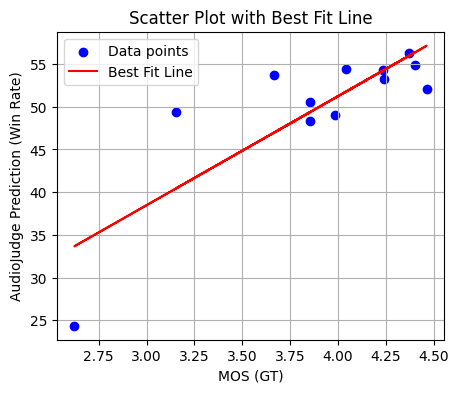

In [405]:
criterion = 'sound' # 'sound', 'rhythm', 'pronunciation'
evaluate_system_level('sound')


Upon listening to both Audio A and Audio B, here is the analysis based on the silence criterion:

1. **Audio A:** In this snippet, the speaker uses pauses effectively, with natural breathing intervals between phrases and words. The silence contributes positively to the flow and coherence of the speech, making it sound natural and easy to follow.

2. **Audio B:** In contrast, this snippet lacks the natural pauses and seems more rushed. There are fewer or no noticeable instances of breathing intervals, which affects the natural rhythm and can make the speech feel hurried or less coherent.

\compare\

In summary, Audio A demonstrates a more refined use of pauses and breathing intervals, resulting in a more natural and coherent delivery. Audio B, while clear, fails to utilize silence effectively, which impacts the overall flow of the speech.

\verdict\ [[A]] \verdict\
Pearson Correlation: 0.717
Spearman Correlation: 0.000


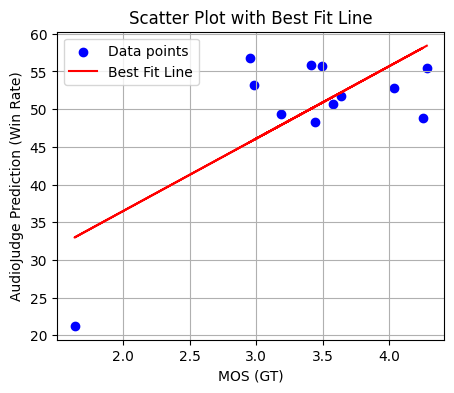

In [324]:
evaluate_system_level('rhythm')


Audio A demonstrated clear pronunciation with each word pronounced distinctly, adhering closely to standard pronunciation norms. The speaker articulated the sounds well, with accurate tones and clarity.

Audio B also showed clarity in pronunciation, but there were slight variations in tone and certain syllables compared to Audio A. Some words were pronounced less distinctly, affecting the overall clarity and adherence to pronunciation norms.

In summary, Audio A had stronger pronunciation due to its precise articulation and clearer adherence to the standard pronunciation of the words in the given text. Meanwhile, Audio B had slight discrepancies in clarity and accuracy.

\verdict\ [[A]] \verdict\
In audio A, the pronunciation is generally clear and adheres closely to standard norms for Thai. Words are articulated correctly, making the sentence easy to understand. In audio B, the pronunciation remains clear but feels slightly less natural, with a focus on careful enunciation that margi

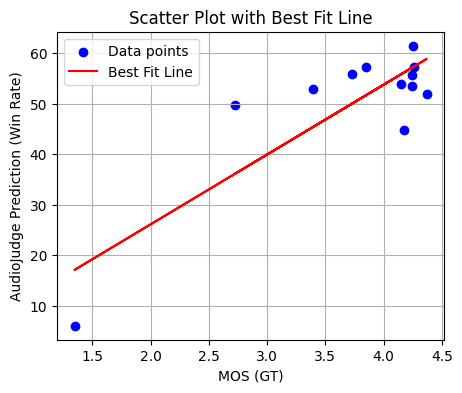

In [407]:
evaluate_system_level('pronunciation')

## Other Baselines

In [330]:
import pandas as pd

total: 3300
correct: 50.79%
Pearson Correlation: 0.166
Spearman Correlation: 0.098


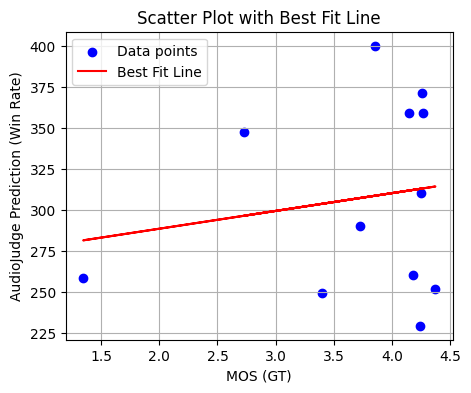

In [376]:
baseline = pd.read_csv("../experiments/eval-datawow_mos.csv")
with open("../data/data_thaimos_pairwise_diffall.json") as f:
    data = json.load(f)
    
correct, count_all = 0, 0

basename_name = 'utmos'
aspect = 'pronunciation' # sound', 'rhythm', 'pronunciation'
pred_by_system, gts_by_system = {}, {}
for data_i in data:
    audio_a, audio_b = data_i
    model_a = audio_a['system']
    model_b = audio_b['system']
    if audio_a[aspect] >= audio_b[aspect]:
        if baseline.iloc[audio_a['datawow_id']-1001][basename_name] >= baseline.iloc[audio_b['datawow_id']-1001][basename_name]:
            correct += 1
    else:
        if baseline.iloc[audio_b['datawow_id']-1001][basename_name] > baseline.iloc[audio_a['datawow_id']-1001][basename_name]:
            correct += 1
    count_all += 1

    if model_a not in pred_by_system: pred_by_system[model_a] = []
    if model_a not in gts_by_system:  gts_by_system[model_a] = []
    if model_b not in pred_by_system: pred_by_system[model_b] = []
    if model_b not in gts_by_system:  gts_by_system[model_b] = []

    pred_by_system[model_a] += [baseline.iloc[audio_a['datawow_id']-1001][basename_name]]
    pred_by_system[model_b] += [baseline.iloc[audio_b['datawow_id']-1001][basename_name]]
    gts_by_system[model_a] += [audio_a[aspect]]
    gts_by_system[model_b] += [audio_b[aspect]]
    
print("total:", count_all)
print("correct: {:.2f}%".format(correct/(count_all)*100))
################################
system_level_pred, system_level_gts = [], []
systems = []
for system, pred in pred_by_system.items():
    gts = gts_by_system[system]
    assert len(pred) == len(gts)
    system_level_pred.append(np.mean(pred)*100)
    system_level_gts.append(np.mean(gts))
    systems.append(system)
analyze_correlation_and_plot(system_level_gts, system_level_pred)

In [ ]:
def read_output_file(path, criterion, reverse=False):
    assert criterion in ['sound', 'rhythm', 'pronunciation']
    outputs = []
    with open(path, "r") as f:
        for line in f:
            x = json.loads(line)
            outputs.append(x)
    
    count_all, count_correct = 0, 0
    predictions = []
    error = 0
    for output in outputs:
        if not reverse:
            audio_a, audio_b = output['data']
        else:
            audio_b, audio_a = output['data']

        if audio_a[criterion] == audio_b[criterion]:
            continue
        
        judge_text = output['response']
        judge_text = post_processing(judge_text)

        
        # Extract content between <explanation> and </explanation>
        explanation_match = re.search(r'<explanation>(.*?)</explanation>', judge_text, re.DOTALL)
        explanation_text = explanation_match.group(1).strip() if explanation_match else None
        
        # Extract content between <verdict> and </verdict>
        verdict_match = re.search(r'<verdict>(.*?)</verdict>', judge_text, re.DOTALL)
        verdict_text = verdict_match.group(1).strip() if verdict_match else None
        try:
            assert verdict_text == "[[A]]" or verdict_text == "[[B]]", f"Unexpected verdict: {judge_text}"
        except:
            # error -- just make it wrong
            print("warning:", judge_text)
            if audio_a[criterion] > audio_b[criterion]: verdict_text = '[[B]]'
            else: verdict_text = '[[A]]'
            error += 1
            
        if verdict_text == "[[A]]":
            if audio_a[criterion] > audio_b[criterion]:
                count_correct += 1
                evaluation = "correct"
            else:
                evaluation = "incorrect"
        elif verdict_text == "[[B]]":
            if audio_a[criterion] < audio_b[criterion]:
                count_correct += 1
                evaluation = "correct"
            else:
                evaluation = "incorrect"
                
        count_all += 1
        predictions.append([evaluation, verdict_text, audio_a[criterion], audio_b[criterion]])
    print("total:", count_all)
    print("error: {:.2f}%".format(error/count_all*100))
    print("accuracy: {:.2f}%".format(count_correct/count_all*100))
    return predictions